In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy

from optics_design_workbench import jupyter_utils

[freecad.optics_design_workbench] python package path /usr/lib/python3.12/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[freecad.optics_design_workbench] python package path /usr/lib/python3.11/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[freecad.optics_design_workbench] python package path /usr/lib/python3.13/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[Optics Design 11:18:22.218996] failed to detect Qt version, used module "PySide6"


In [ ]:
# sleep a bit to ensure that all canceled previous simulations timed out
time.sleep(15)

# Run simulations for various lens radii

In [2]:
for simulationMode in ('fans', 'pseudo', 'true'):
  # prepare arrays/lists for parameters/results
  radii = linspace(36, 58, 5)
  results = []

  # open FCStd Document as a context manager. The context manager makes sure
  # the file is closed again with certainty. Keep in mind that if the file is
  # open in another FreeCAD GUI, saving from the Gui will overwrite the file
  # and may leads to inconsistent file versions being seen by different 
  # worker processes.
  with jupyter_utils.FreecadDocument('lens-optimizer.FCStd') as f:

    # setup progress tracking
    jupyter_utils.setupProgressTracker(totalSimulations=len(radii))

    # try different radii
    for rad in radii:

      # update radius and placement of both spheres that form the lens
      f.Sphere001.Radius = rad
      f.Sphere001.Placement.Base = [0, 0, -rad/1.2]
      f.Sphere.Radius = rad
      f.Sphere.Placement.Base = [0, 0, rad/1.2]

      # run a simulation
      results.append( f.runSimulation(simulationMode) )


simulation 5/5
simulations ended after 30s


In [3]:
# show list of the first ten results
results[:10]

[<RawFolder simulation-run-000869/ UID=6e413c5b-14d2-4c84-8e33-e7e6d9d4ee02>,
 <RawFolder simulation-run-000870/ UID=f3c156b0-0e23-4504-a473-1f812ad160e4>,
 <RawFolder simulation-run-000871/ UID=fe58ebaa-a1f0-41fe-92d2-bae609d7737d>,
 <RawFolder simulation-run-000872/ UID=ec28975d-d9c9-4f66-9ad2-61a9c1c31734>,
 <RawFolder simulation-run-000873/ UID=4269a9a3-fc72-4caa-abc8-26b8219f2836>]

In [4]:
# print filesystem tree overview of first result file:
results[0].printTree()

simulation-run-000869/
  source-OpticalPointSource/
    object-OpticalAbsorberGroup/
      <1 hit files>


# Create histograms and do Gauss fit for each histogram

In [5]:
gauss = lambda X, amp, x0, sigma: amp*exp(-(X-x0)**2/sigma**2)

In [9]:
sigmas, x0s, _Hs = [], [], []
for r in results:
  hits = r.loadHits('*')
  H, X, Y = jupyter_utils.planarHistogram(hits, bins=(300, 301), XY='centers') #XY='edges')

  #figure(figsize=(4,4))
  #pcolormesh(X, Y, H.T)
  #show()
  
  #figure(figsize=(4,4))
  _H = H.sum(axis=1)
  #plot(X, _H)
  try:
    (amp, x0, sigma), _ = scipy.optimize.curve_fit(gauss, X, _H, p0=(max(_H), 0, 1))
  except Exception:
    amp, x0, sigma = nan, nan, nan
  #plot(X, gauss(X, amp, x0, sigma))
  #show()

  sigmas.append(sigma)
  x0s.append(x0)
  _Hs.append(_H)
x0s, sigmas = array(x0s), array(sigmas)

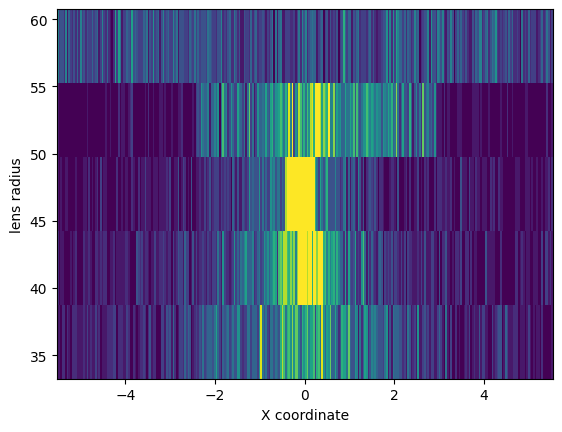

In [10]:
import matplotlib.colors as col
_Hs = array(_Hs)
pcolormesh(X, radii, _Hs, norm=col.Normalize(_Hs.min(), _Hs.max()/5, clip=True))
xlabel('X coordinate')
ylabel('lens radius')
savefig('lens-optimizer-sweep-result.jpg')

[]

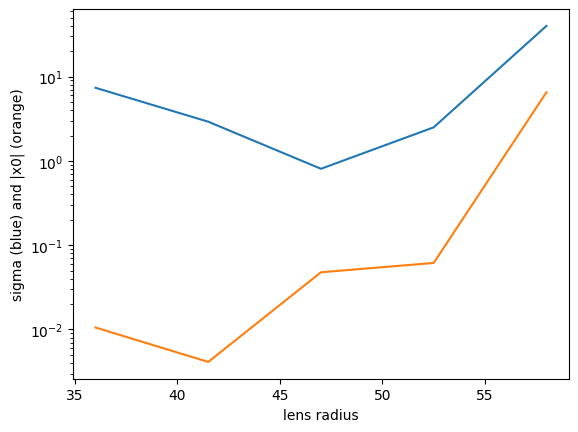

In [11]:
plot(radii, sigmas)
plot(radii, abs(x0s))
xlabel('lens radius')
ylabel('sigma (blue) and |x0| (orange)')
semilogy()